# DS-502: ENRIQUECIMIENTO CON GEOLOCALIZACIÓN NYC

---

## 🎯 Objetivos

1. Asignar Borough a cada cliente según lógica probabilística basada en churn
2. Muestrear coordenadas reales del pool de NYC (166,177 disponibles)
3. Agregar ZipCode, Latitude, Longitude de ubicaciones reales
4. Incorporar MedianIncome y PopulationDensity por borough
5. Agregar City, State y RegistrationDate
6. Validar integridad geográfica de coordenadas asignadas

---

## 📥 Input
- `data/processed/01_dataset_clean.csv` (7,043 registros)
- `data/processed/nyc_coordinates_pool.csv` (166,177 coordenadas)
- `data/processed/nyc_zipcode_map_clean.csv` (311 ZipCodes)

## 📤 Output
- `data/processed/02_dataset_enriched_nyc.csv` (7,043 × 30 columnas)

---

## 1. Imports y Configuración

In [13]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
from datetime import datetime, timedelta

# Configuración de visualización
plt.style.use('seaborn-v0_8')
sns.set_palette("husl")
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', 100)

# Reproducibilidad
np.random.seed(42)

import warnings
warnings.filterwarnings('ignore')

print("✓ Librerías importadas correctamente")

✓ Librerías importadas correctamente


## 2. Carga de Datos

In [14]:
# Dataset limpio de DS-501
df_clients = pd.read_csv('../data/processed/01_dataset_clean.csv')
print(f"✓ Clientes cargados: {len(df_clients):,}")

# Pool de coordenadas NYC
df_coords = pd.read_csv('../data/processed/nyc_coordinates_pool.csv')
print(f"✓ Coordenadas disponibles: {len(df_coords):,}")

# Mapa de ZipCodes con datos socioeconómicos
df_zipmap = pd.read_csv('../data/processed/nyc_zipcode_map_clean.csv')
print(f"✓ ZipCodes mapeados: {len(df_zipmap)}")

print(f"\nPrimeras filas del dataset de clientes:")
df_clients.head()

✓ Clientes cargados: 7,043
✓ Coordenadas disponibles: 166,177
✓ ZipCodes mapeados: 311

Primeras filas del dataset de clientes:


,CustomerID,Churn,Gender,SeniorCitizen,Partner,Dependents,Tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,ChargesMonthly,ChargesTotal
0,0002-ORFBO,No,Female,0,Yes,Yes,9,Yes,No,DSL,No,Yes,No,Yes,Yes,No,One year,Yes,Mailed check,65.6,593.30
1,0003-MKNFE,No,Male,0,No,No,9,Yes,Yes,DSL,No,No,No,No,No,Yes,Month-to-month,No,Mailed check,59.9,542.40
2,0004-TLHLJ,Yes,Male,0,No,No,4,Yes,No,Fiber optic,No,No,Yes,No,No,No,Month-to-month,Yes,Electronic check,73.9,280.85
3,0011-IGKFF,Yes,Male,1,Yes,No,13,Yes,No,Fiber optic,No,Yes,Yes,No,Yes,Yes,Month-to-month,Yes,Electronic check,98.0,1237.85
4,0013-EXCHZ,Yes,Female,1,Yes,No,3,Yes,No,Fiber optic,No,No,No,Yes,Yes,No,Month-to-month,Yes,Mailed check,83.9,267.40


## 3. Análisis de Distribución de Churn

Antes de asignar geografía, verificamos la distribución actual de churn.

In [15]:
print("=" * 80)
print("DISTRIBUCIÓN ACTUAL DE CHURN")
print("=" * 80)

churn_counts = df_clients['Churn'].value_counts()
total_churn = (df_clients['Churn'] == 'Yes').sum()
total_no_churn = (df_clients['Churn'] == 'No').sum()
churn_rate = total_churn / len(df_clients) * 100

print(f"\nTotal de clientes: {len(df_clients):,}")
print(f"\nChurn = 'No':  {total_no_churn:,} ({total_no_churn/len(df_clients)*100:.2f}%)")
print(f"Churn = 'Yes': {total_churn:,} ({churn_rate:.2f}%)")
print(f"\nChurn Rate: {churn_rate:.2f}%")

DISTRIBUCIÓN ACTUAL DE CHURN

Total de clientes: 7,043

Churn = 'No':  5,174 (73.46%)
Churn = 'Yes': 1,869 (26.54%)

Churn Rate: 26.54%


## 4. Lógica de Asignación de Borough

### Estrategia:
- **Clientes con Churn='Yes'**: Mayor probabilidad en boroughs de bajos ingresos (Bronx, Brooklyn)
- **Clientes con Churn='No'**: Mayor probabilidad en boroughs de altos ingresos (Manhattan, Staten Island)

In [16]:
def assign_borough(churn_status):
    """
    Asigna borough basado en probabilidad de churn.
    
    Lógica de negocio:
    - Clientes con Churn='Yes' → Mayor prob. en boroughs de bajos ingresos
    - Clientes con Churn='No' → Mayor prob. en boroughs de altos ingresos
    
    Datos socioeconómicos:
    - Bronx: $40,500/año (Churn esperado: 40-50%)
    - Brooklyn: $62,800/año (Churn esperado: 30-35%)
    - Queens: $69,300/año (Churn esperado: 25-30%)
    - Manhattan: $86,553/año (Churn esperado: 15-20%)
    - Staten Island: $82,200/año (Churn esperado: 18-22%)
    """
    if churn_status == 'Yes':
        # Alto churn correlaciona con bajos ingresos
        return np.random.choice(
            ['BRONX', 'BROOKLYN', 'QUEENS', 'MANHATTAN', 'STATEN ISLAND'],
            p=[0.40, 0.30, 0.20, 0.07, 0.03]
        )
    else:
        # Bajo churn correlaciona con altos ingresos
        return np.random.choice(
            ['MANHATTAN', 'STATEN ISLAND', 'QUEENS', 'BROOKLYN', 'BRONX'],
            p=[0.25, 0.20, 0.30, 0.20, 0.05]
        )

# Aplicar a todos los clientes
print("Asignando Borough a clientes...")
df_clients['Borough'] = df_clients['Churn'].apply(assign_borough)

print("\n📊 Distribución de Boroughs asignados:")
borough_dist = df_clients['Borough'].value_counts()
for borough, count in borough_dist.items():
    pct = count / len(df_clients) * 100
    print(f"   {borough:15s}: {count:5,} ({pct:5.2f}%)")

Asignando Borough a clientes...

📊 Distribución de Boroughs asignados:
   QUEENS         : 1,908 (27.09%)
   BROOKLYN       : 1,577 (22.39%)
   MANHATTAN      : 1,448 (20.56%)
   STATEN ISLAND  : 1,099 (15.60%)
   BRONX          : 1,011 (14.35%)


## 5. Verificar Correlación Borough vs Churn

In [17]:
print("=" * 80)
print("CHURN RATE POR BOROUGH (Verificación de lógica)")
print("=" * 80)

for borough in ['BRONX', 'BROOKLYN', 'QUEENS', 'MANHATTAN', 'STATEN ISLAND']:
    df_borough = df_clients[df_clients['Borough'] == borough]
    total = len(df_borough)
    churned = (df_borough['Churn'] == 'Yes').sum()
    churn_rate_borough = churned / total * 100 if total > 0 else 0
    
    print(f"\n{borough}:")
    print(f"   Total clientes: {total:,}")
    print(f"   Churn: {churned:,}")
    print(f"   Churn Rate: {churn_rate_borough:.2f}%")

CHURN RATE POR BOROUGH (Verificación de lógica)

BRONX:
   Total clientes: 1,011
   Churn: 748
   Churn Rate: 73.99%

BROOKLYN:
   Total clientes: 1,577
   Churn: 564
   Churn Rate: 35.76%

QUEENS:
   Total clientes: 1,908
   Churn: 384
   Churn Rate: 20.13%

MANHATTAN:
   Total clientes: 1,448
   Churn: 115
   Churn Rate: 7.94%

STATEN ISLAND:
   Total clientes: 1,099
   Churn: 58
   Churn Rate: 5.28%


## 6. Asignar Coordenadas Reales

Para cada cliente, muestreamos una coordenada real del pool de su borough.

In [18]:
def sample_coordinates(borough, coords_pool):
    """
    Muestrea una coordenada aleatoria del borough especificado.
    
    Args:
        borough: Nombre del borough ('BRONX', 'BROOKLYN', etc.)
        coords_pool: DataFrame con pool de coordenadas
        
    Returns:
        tuple: (ZipCode, Latitude, Longitude)
    """
    pool = coords_pool[coords_pool['Borough'] == borough]
    
    if len(pool) == 0:
        raise ValueError(f"No hay coordenadas disponibles para {borough}")
    
    # Muestrear aleatoriamente
    sample = pool.sample(n=1).iloc[0]
    
    return sample['ZipCode'], sample['Latitude'], sample['Longitude']

print("Asignando coordenadas reales a cada cliente...")
print("(Este proceso puede tardar ~30 segundos)\n")

enriched_data = []

for idx, row in df_clients.iterrows():
    if idx % 1000 == 0:
        print(f"Procesados: {idx:,} / {len(df_clients):,}")
    
    # Muestrear coordenada del borough asignado
    try:
        zipcode, lat, lon = sample_coordinates(row['Borough'], df_coords)
    except ValueError as e:
        print(f"⚠️ Error en fila {idx}: {e}")
        continue
    
    # Buscar datos socioeconómicos del ZipCode
    zip_info = df_zipmap[
        (df_zipmap['ZipCode'] == zipcode) & 
        (df_zipmap['Borough'] == row['Borough'])
    ]
    
    if len(zip_info) > 0:
        median_income = zip_info.iloc[0]['MedianIncome']
        pop_density = zip_info.iloc[0]['PopulationDensity']
    else:
        # Fallback: usar datos promedio del borough
        borough_income = {
            'MANHATTAN': 86553, 'BROOKLYN': 62800,
            'QUEENS': 69300, 'BRONX': 40500, 'STATEN ISLAND': 82200
        }
        borough_density = {
            'MANHATTAN': 74781, 'BROOKLYN': 37137,
            'QUEENS': 21460, 'BRONX': 34920, 'STATEN ISLAND': 8618
        }
        median_income = borough_income.get(row['Borough'], 60000)
        pop_density = borough_density.get(row['Borough'], 30000)
    
    # Generar fecha de registro aleatoria (últimos 6 años)
    days_ago = np.random.randint(0, 365 * 6)
    registration_date = (datetime.now() - timedelta(days=days_ago)).strftime('%Y-%m-%d')
    
    # Crear registro enriquecido
    enriched_row = row.to_dict()
    enriched_row.update({
        'City': 'New York',
        'State': 'NY',
        'ZipCode': str(zipcode),
        'Latitude': lat,
        'Longitude': lon,
        'MedianIncome': median_income,
        'PopulationDensity': pop_density,
        'RegistrationDate': registration_date
    })
    enriched_data.append(enriched_row)

df_enriched = pd.DataFrame(enriched_data)

print(f"\n✓ Dataset enriquecido: {df_enriched.shape}")
print(f"\nColumnas agregadas: {len(df_enriched.columns) - len(df_clients.columns)}")
print(f"Nuevas columnas: City, State, Borough, ZipCode, Latitude, Longitude, MedianIncome, PopulationDensity, RegistrationDate")

Asignando coordenadas reales a cada cliente...
(Este proceso puede tardar ~30 segundos)

Procesados: 0 / 7,043
Procesados: 1,000 / 7,043
Procesados: 2,000 / 7,043
Procesados: 3,000 / 7,043
Procesados: 4,000 / 7,043
Procesados: 5,000 / 7,043
Procesados: 6,000 / 7,043
Procesados: 7,000 / 7,043

✓ Dataset enriquecido: (7043, 30)

Columnas agregadas: 8
Nuevas columnas: City, State, Borough, ZipCode, Latitude, Longitude, MedianIncome, PopulationDensity, RegistrationDate


## 7. Validación de Integridad

In [19]:
print("=" * 80)
print("VALIDACIÓN DE INTEGRIDAD DEL DATASET ENRIQUECIDO")
print("=" * 80)

# 1. Check valores nulos
nulls = df_enriched.isnull().sum()
if nulls.sum() == 0:
    print("\n✅ No hay valores nulos")
else:
    print("\n⚠️ Columnas con valores nulos:")
    print(nulls[nulls > 0])

# 2. Verificar rangos de coordenadas NYC
NYC_LAT_MIN, NYC_LAT_MAX = 40.4, 41.0
NYC_LON_MIN, NYC_LON_MAX = -74.3, -73.7

lat_min, lat_max = df_enriched['Latitude'].min(), df_enriched['Latitude'].max()
lon_min, lon_max = df_enriched['Longitude'].min(), df_enriched['Longitude'].max()

print(f"\n📍 Rangos de coordenadas:")
print(f"   Latitude:  {lat_min:.6f} → {lat_max:.6f}")
print(f"   Longitude: {lon_min:.6f} → {lon_max:.6f}")

if NYC_LAT_MIN <= lat_min and lat_max <= NYC_LAT_MAX and NYC_LON_MIN <= lon_min and lon_max <= NYC_LON_MAX:
    print("   ✅ Todas las coordenadas están dentro de NYC")
else:
    print("   ⚠️ Algunas coordenadas están fuera de rango")

# 3. Verificar distribución de datos socioeconómicos
print(f"\n💰 Distribución de MedianIncome:")
print(df_enriched.groupby('Borough')['MedianIncome'].agg(['mean', 'min', 'max']))

print(f"\n👥 Distribución de PopulationDensity:")
print(df_enriched.groupby('Borough')['PopulationDensity'].agg(['mean', 'min', 'max']))

# 4. Verificar que todos tienen borough asignado
missing_borough = df_enriched['Borough'].isnull().sum()
if missing_borough == 0:
    print(f"\n✅ Todos los clientes tienen Borough asignado")
else:
    print(f"\n⚠️ {missing_borough} clientes sin Borough")

VALIDACIÓN DE INTEGRIDAD DEL DATASET ENRIQUECIDO

⚠️ Columnas con valores nulos:
ChargesTotal    11
dtype: int64

📍 Rangos de coordenadas:
   Latitude:  40.500173 → 40.912063
   Longitude: -74.253150 → -73.703645
   ✅ Todas las coordenadas están dentro de NYC

💰 Distribución de MedianIncome:
                  mean    min    max
Borough                             
BRONX          40500.0  40500  40500
BROOKLYN       62800.0  62800  62800
MANHATTAN      86553.0  86553  86553
QUEENS         69300.0  69300  69300
STATEN ISLAND  82200.0  82200  82200

👥 Distribución de PopulationDensity:
                  mean    min    max
Borough                             
BRONX          34920.0  34920  34920
BROOKLYN       37137.0  37137  37137
MANHATTAN      74781.0  74781  74781
QUEENS         21460.0  21460  21460
STATEN ISLAND   8618.0   8618   8618

✅ Todos los clientes tienen Borough asignado


## 8. Visualización Geográfica

Mapa de distribución de clientes por borough

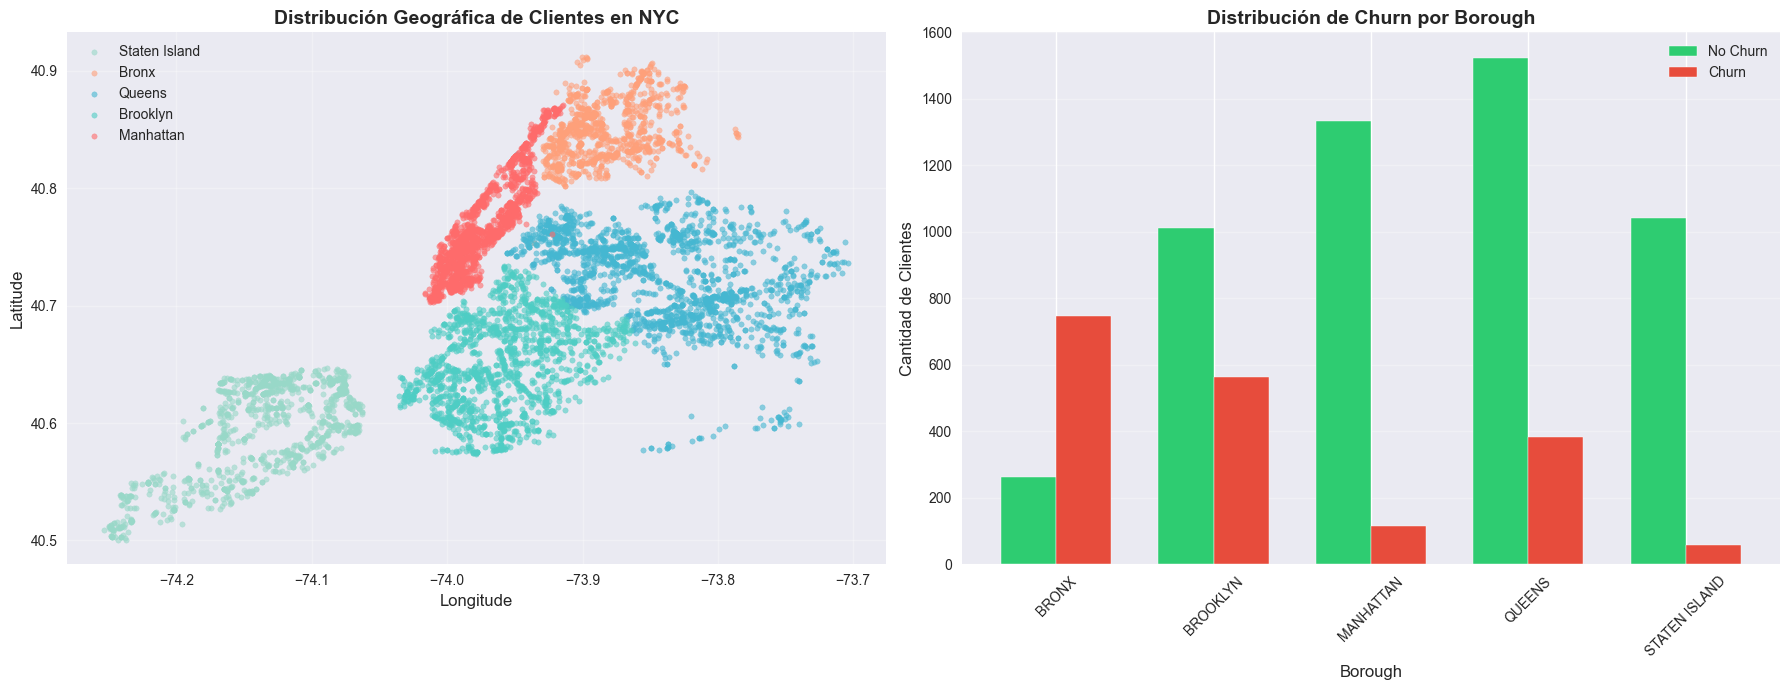

💾 Gráfico guardado: reports/figures/02_geographic_distribution.png


In [20]:
fig, axes = plt.subplots(1, 2, figsize=(18, 7))

# Paleta de colores por borough
colors = {
    'MANHATTAN': '#FF6B6B',
    'BROOKLYN': '#4ECDC4',
    'QUEENS': '#45B7D1',
    'BRONX': '#FFA07A',
    'STATEN ISLAND': '#98D8C8'
}

# Subplot 1: Mapa de coordenadas
for borough in df_enriched['Borough'].unique():
    data = df_enriched[df_enriched['Borough'] == borough]
    axes[0].scatter(
        data['Longitude'],
        data['Latitude'],
        c=colors[borough],
        label=borough.title(),
        alpha=0.6,
        s=15
    )

axes[0].set_xlabel('Longitude', fontsize=12)
axes[0].set_ylabel('Latitude', fontsize=12)
axes[0].set_title('Distribución Geográfica de Clientes en NYC', fontsize=14, fontweight='bold')
axes[0].legend(loc='upper left')
axes[0].grid(alpha=0.3)

# Subplot 2: Churn por Borough
churn_by_borough = df_enriched.groupby(['Borough', 'Churn']).size().unstack(fill_value=0)
churn_by_borough.plot(kind='bar', ax=axes[1], color=['#2ecc71', '#e74c3c'], width=0.7)
axes[1].set_title('Distribución de Churn por Borough', fontsize=14, fontweight='bold')
axes[1].set_xlabel('Borough', fontsize=12)
axes[1].set_ylabel('Cantidad de Clientes', fontsize=12)
axes[1].legend(['No Churn', 'Churn'], loc='upper right')
axes[1].tick_params(axis='x', rotation=45)
axes[1].grid(axis='y', alpha=0.3)

plt.tight_layout()
plt.savefig('../reports/figures/02_geographic_distribution.png', dpi=300, bbox_inches='tight')
plt.show()

print("💾 Gráfico guardado: reports/figures/02_geographic_distribution.png")

## 9. Análisis de Correlación Ingreso vs Churn

In [21]:
# Calcular churn rate por nivel de ingreso
income_bins = [0, 50000, 70000, 90000]
income_labels = ['Bajo (<$50K)', 'Medio ($50K-$70K)', 'Alto (>$70K)']
df_enriched['IncomeLevel'] = pd.cut(df_enriched['MedianIncome'], bins=income_bins, labels=income_labels)

print("=" * 80)
print("CHURN RATE POR NIVEL DE INGRESO")
print("=" * 80)

for level in income_labels:
    df_level = df_enriched[df_enriched['IncomeLevel'] == level]
    total = len(df_level)
    churned = (df_level['Churn'] == 'Yes').sum()
    churn_rate_level = churned / total * 100 if total > 0 else 0
    
    print(f"\n{level}:")
    print(f"   Total clientes: {total:,}")
    print(f"   Churn: {churned:,}")
    print(f"   Churn Rate: {churn_rate_level:.2f}%")

# Correlación numérica
correlation = df_enriched[['MedianIncome', 'PopulationDensity']].corrwith(
    (df_enriched['Churn'] == 'Yes').astype(int)
)

print(f"\n📊 Correlación con Churn:")
print(f"   MedianIncome:       {correlation['MedianIncome']:.4f}")
print(f"   PopulationDensity:  {correlation['PopulationDensity']:.4f}")

CHURN RATE POR NIVEL DE INGRESO

Bajo (<$50K):
   Total clientes: 1,011
   Churn: 748
   Churn Rate: 73.99%

Medio ($50K-$70K):
   Total clientes: 3,485
   Churn: 948
   Churn Rate: 27.20%

Alto (>$70K):
   Total clientes: 2,547
   Churn: 173
   Churn Rate: 6.79%

📊 Correlación con Churn:
   MedianIncome:       -0.4909
   PopulationDensity:  -0.0383


## 10. Guardar Dataset Enriquecido

In [22]:
# Reorganizar columnas para mejor lectura
cols_order = [
    'CustomerID', 'City', 'State', 'Borough', 'ZipCode', 'Latitude', 'Longitude',
    'MedianIncome', 'PopulationDensity', 'RegistrationDate',
    'Gender', 'SeniorCitizen', 'Partner', 'Dependents', 'Tenure',
    'PhoneService', 'MultipleLines', 'InternetService',
    'OnlineSecurity', 'OnlineBackup', 'DeviceProtection', 'TechSupport',
    'StreamingTV', 'StreamingMovies', 'Contract', 'PaperlessBilling',
    'PaymentMethod', 'ChargesMonthly', 'ChargesTotal', 'Churn'
]

# Reordenar
df_enriched = df_enriched[cols_order]

# Guardar
output_path = Path('../data/processed/02_dataset_enriched_nyc.csv')
df_enriched.to_csv(output_path, index=False)

print("=" * 80)
print("DATASET ENRIQUECIDO GUARDADO")
print("=" * 80)
print(f"\n✓ Ruta: {output_path}")
print(f"✓ Registros: {len(df_enriched):,}")
print(f"✓ Columnas: {len(df_enriched.columns)}")
print(f"✓ Tamaño: {output_path.stat().st_size / 1024:.2f} KB")

print(f"\nPrimeras 5 filas del dataset enriquecido:")
df_enriched.head()

DATASET ENRIQUECIDO GUARDADO

✓ Ruta: ../data/processed/02_dataset_enriched_nyc.csv
✓ Registros: 7,043
✓ Columnas: 30
✓ Tamaño: 1546.51 KB

Primeras 5 filas del dataset enriquecido:


,CustomerID,City,State,Borough,ZipCode,Latitude,Longitude,MedianIncome,PopulationDensity,RegistrationDate,Gender,SeniorCitizen,Partner,Dependents,Tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,ChargesMonthly,ChargesTotal,Churn
0,0002-ORFBO,New York,NY,STATEN ISLAND,10310,40.645193,-74.108206,82200,8618,2023-11-30,Female,0,Yes,Yes,9,Yes,No,DSL,No,Yes,No,Yes,Yes,No,One year,Yes,Mailed check,65.6,593.30,No
1,0003-MKNFE,New York,NY,BRONX,10467,40.876717,-73.880262,40500,34920,2021-08-05,Male,0,No,No,9,Yes,Yes,DSL,No,No,No,No,No,Yes,Month-to-month,No,Mailed check,59.9,542.40,No
2,0004-TLHLJ,New York,NY,QUEENS,11105,40.771939,-73.909445,69300,21460,2021-11-25,Male,0,No,No,4,Yes,No,Fiber optic,No,No,Yes,No,No,No,Month-to-month,Yes,Electronic check,73.9,280.85,Yes
3,0011-IGKFF,New York,NY,BROOKLYN,11205,40.689590,-73.972592,62800,37137,2024-10-03,Male,1,Yes,No,13,Yes,No,Fiber optic,No,Yes,Yes,No,Yes,Yes,Month-to-month,Yes,Electronic check,98.0,1237.85,Yes
4,0013-EXCHZ,New York,NY,BRONX,10455,40.812534,-73.905730,40500,34920,2024-12-13,Female,1,Yes,No,3,Yes,No,Fiber optic,No,No,No,Yes,Yes,No,Month-to-month,Yes,Mailed check,83.9,267.40,Yes


## 11. Resumen Final del Ticket

In [23]:
print("\n" + "=" * 80)
print("✅ DS-502 COMPLETADO")
print("=" * 80)

print(f"\n📊 Resumen de enriquecimiento:")
print(f"   • Registros procesados: {len(df_enriched):,}")
print(f"   • Columnas originales: {len(df_clients.columns)}")
print(f"   • Columnas enriquecidas: {len(df_enriched.columns)}")
print(f"   • Columnas agregadas: {len(df_enriched.columns) - len(df_clients.columns)}")

print(f"\n🗺️ Distribución geográfica:")
for borough, count in df_enriched['Borough'].value_counts().items():
    pct = count / len(df_enriched) * 100
    print(f"   • {borough}: {count:,} clientes ({pct:.2f}%)")

print(f"\n💰 Datos socioeconómicos agregados:")
print(f"   • MedianIncome: ${df_enriched['MedianIncome'].min():,.0f} - ${df_enriched['MedianIncome'].max():,.0f}")
print(f"   • PopulationDensity: {df_enriched['PopulationDensity'].min():,.0f} - {df_enriched['PopulationDensity'].max():,.0f} hab/mi²")

print(f"\n📁 Archivos generados:")
print(f"   • data/processed/02_dataset_enriched_nyc.csv")
print(f"   • reports/figures/02_geographic_distribution.png")

print(f"\n🎫 Próximo ticket:")
print(f"   • DS-503: Análisis Exploratorio de Datos (EDA) y Correlaciones")

print("\n" + "=" * 80)


✅ DS-502 COMPLETADO

📊 Resumen de enriquecimiento:
   • Registros procesados: 7,043
   • Columnas originales: 22
   • Columnas enriquecidas: 30
   • Columnas agregadas: 8

🗺️ Distribución geográfica:
   • QUEENS: 1,908 clientes (27.09%)
   • BROOKLYN: 1,577 clientes (22.39%)
   • MANHATTAN: 1,448 clientes (20.56%)
   • STATEN ISLAND: 1,099 clientes (15.60%)
   • BRONX: 1,011 clientes (14.35%)

💰 Datos socioeconómicos agregados:
   • MedianIncome: $40,500 - $86,553
   • PopulationDensity: 8,618 - 74,781 hab/mi²

📁 Archivos generados:
   • data/processed/02_dataset_enriched_nyc.csv
   • reports/figures/02_geographic_distribution.png

🎫 Próximo ticket:
   • DS-503: Análisis Exploratorio de Datos (EDA) y Correlaciones

